In [1]:
# The demographic data comes from 2010 census district data found at https://www.census.gov/mycd/
# The election results comes from the New York Times.  These are the House election results.

import sphinx
import pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn import tree
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier


"""
ProjectDataset lists every district in the United States, their demographics, and their 
election results.  Each row is a district, with its total population, median age, 
percentage of the population that's male, percentage of the population that is white, and
what the election results were for the 2012, 2014, 2016, and 2018 elections.
"""

data = pd.read_csv("ProjectDataset.csv")

data.head()


,State,District,Total Population,Median Age,Male Pop,Female Pop,Male Pct,White Pop,White Pct,2012 Outcome,2014 Outcome,2016 Outcome,2018 Outcome
0,Alabama,1,713410,40.0,343769,369641,0.481867,479792,0.672533,Republican,Republican,Republican,Republican
1,Alabama,2,673776,38.5,328474,345302,0.487512,434984,0.645591,Republican,Republican,Republican,Republican
2,Alabama,3,710488,38.1,346742,363746,0.488034,487936,0.686762,Republican,Republican,Republican,Republican
3,Alabama,4,685553,40.7,332923,352630,0.485627,594163,0.866692,Republican,Republican,Republican,Republican
4,Alabama,5,718713,39.5,353533,365180,0.491897,544610,0.757757,Republican,Republican,Republican,Republican


In [2]:
"""
sklearn's DecisionTreeClassifier requires all attributes to be numeric so the outcome labels 
(Republican and Democrat) must be converted to integers (0 and 1).
Republicans are labeled as 0, Democrats are labeled as 1.
"""

converted_rep = data.replace(['Republican'], 0)
numeric_data = converted_rep.replace(['Democrat'], 1)
numeric_data.head()

,State,District,Total Population,Median Age,Male Pop,Female Pop,Male Pct,White Pop,White Pct,2012 Outcome,2014 Outcome,2016 Outcome,2018 Outcome
0,Alabama,1,713410,40.0,343769,369641,0.481867,479792,0.672533,0,0,0,0
1,Alabama,2,673776,38.5,328474,345302,0.487512,434984,0.645591,0,0,0,0
2,Alabama,3,710488,38.1,346742,363746,0.488034,487936,0.686762,0,0,0,0
3,Alabama,4,685553,40.7,332923,352630,0.485627,594163,0.866692,0,0,0,0
4,Alabama,5,718713,39.5,353533,365180,0.491897,544610,0.757757,0,0,0,0


In [3]:
"""
Baseline model: Predict 2018 election based on how states voted 
in the 2012, 2014, and 2016 elections.
"""

Y_base = numeric_data['2018 Outcome']
X_base = numeric_data[['2012 Outcome', '2014 Outcome', '2016 Outcome']]
Xbase_train, Xbase_test, Ybase_train, Ybase_test = train_test_split(X_base, Y_base, test_size=0.3, random_state=1)
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(Xbase_train, Ybase_train)
Ybase_pred = clf.predict(Xbase_test)
accuracy_score(Ybase_test, Ybase_pred)

0.8854961832061069

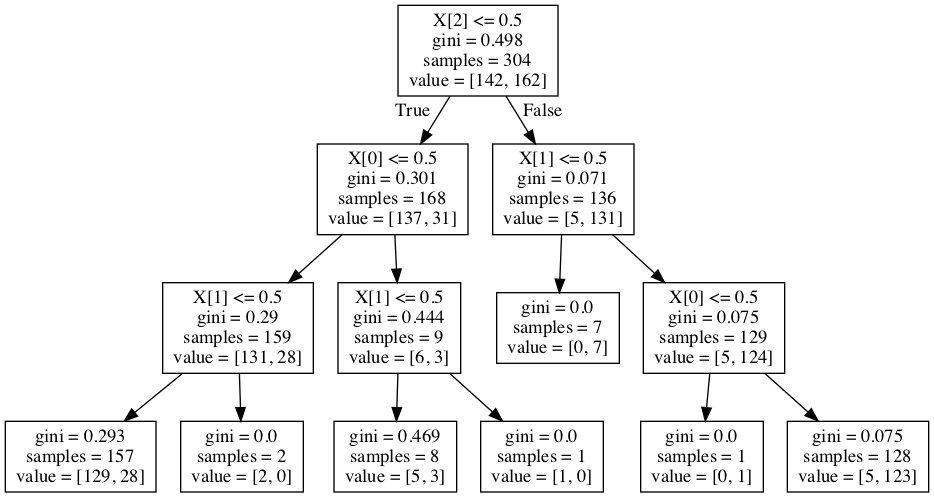

In [4]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("electionsbase.pdf") 

Image(graph.create_png())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

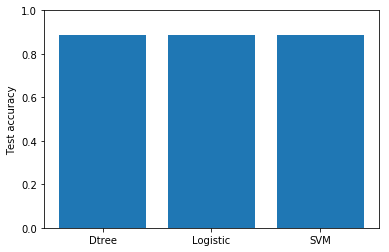

In [5]:
# Test with other classification methods

clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(Xbase_train, Ybase_train)
Ybase_pred = clf.predict(Xbase_test)
tree_acc=accuracy_score(Ybase_test, Ybase_pred)

clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(Xbase_train, Ybase_train)
Ybase_pred = clf.predict(Xbase_test)
logistic_acc=accuracy_score(Ybase_test, Ybase_pred)

clf = SVC(C=10,kernel='linear')
clf = clf.fit(Xbase_train, Ybase_train)
Ybase_pred = clf.predict(Xbase_test)
svm_acc=accuracy_score(Ybase_test, Ybase_pred)

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

In [6]:
"""
Now test if demographics improves this accuracy.
"""

Y_demographics = numeric_data['2018 Outcome']
X_demographics = numeric_data[['Total Population', 'Median Age', 'Male Pct', 'White Pct', '2012 Outcome', '2014 Outcome', '2016 Outcome']]
X_train, X_test, Y_train, Y_test = train_test_split(X_demographics, Y_demographics, test_size=0.3, random_state=1)
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.8320610687022901

Best hyperparameter, maxdepth = 2
Test Accuracy = 0.8854961832061069


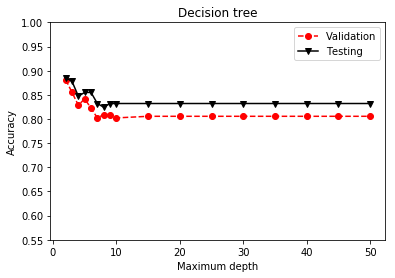

In [7]:
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
validationAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

numFolds = 5
index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=1)
    scores = cross_val_score(clf, X_train, Y_train, cv=numFolds)
    validationAcc[index] = np.mean(scores)
    
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    testAcc[index] = accuracy_score(Y_test, Y_pred)
    index += 1
    
plt.plot(maxdepths, validationAcc, 'ro--', maxdepths, testAcc, 'kv-')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.title('Decision tree')
plt.legend(['Validation','Testing'])
plt.ylim([0.55,1.0])

bestHyperparam = np.argmax(validationAcc)
print('Best hyperparameter, maxdepth =', maxdepths[bestHyperparam])
print('Test Accuracy =', testAcc[bestHyperparam])

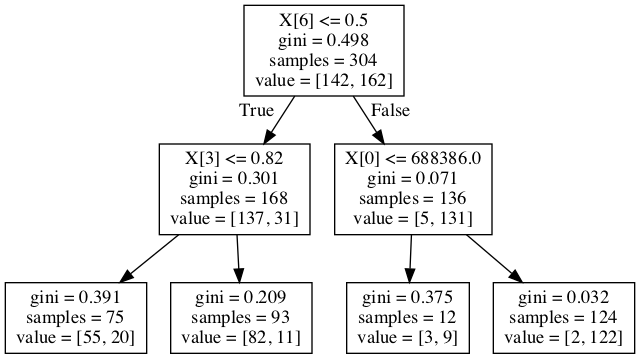

In [8]:
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=1)
clf = clf.fit(X_train, Y_train)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("electionsdemographics.pdf") 

Image(graph.create_png())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

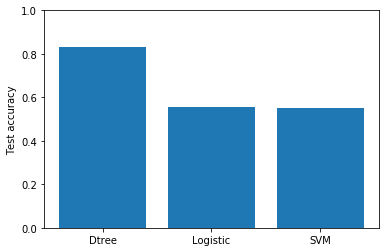

In [9]:
# Test with other classification methods

clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
tree_acc=accuracy_score(Y_test, Y_pred)

clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
logistic_acc=accuracy_score(Y_test, Y_pred)

clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
svm_acc=accuracy_score(Y_test, Y_pred)

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

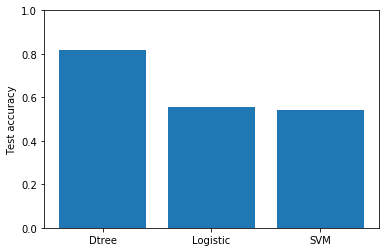

In [10]:
# Use Total District Population only

Y_pop = numeric_data['2018 Outcome']
X_pop = numeric_data[['Total Population', '2012 Outcome', '2014 Outcome', '2016 Outcome']]

X_train, X_test, Y_train, Y_test = train_test_split(X_pop, Y_pop, test_size=0.3, random_state=1)

clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
tree_acc=accuracy_score(Y_test, Y_pred)

clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
logistic_acc=accuracy_score(Y_test, Y_pred)

clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
svm_acc=accuracy_score(Y_test, Y_pred)

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

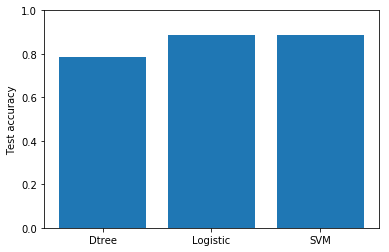

In [11]:
# Use Median Age Only
Y_age = numeric_data['2018 Outcome']
X_age = numeric_data[['Median Age', '2012 Outcome', '2014 Outcome', '2016 Outcome']]
X_train, X_test, Y_train, Y_test = train_test_split(X_age, Y_age, test_size=0.3, random_state=1)

clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
tree_acc=accuracy_score(Y_test, Y_pred)

clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
logistic_acc=accuracy_score(Y_test, Y_pred)

clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
svm_acc=accuracy_score(Y_test, Y_pred)

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

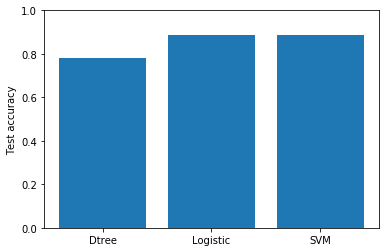

In [12]:
# Use Male Percentage Only
Y_male = numeric_data['2018 Outcome']
X_male = numeric_data[['Male Pct', '2012 Outcome', '2014 Outcome', '2016 Outcome']]
X_train, X_test, Y_train, Y_test = train_test_split(X_male, Y_male, test_size=0.3, random_state=1)

clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
tree_acc=accuracy_score(Y_test, Y_pred)

clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
logistic_acc=accuracy_score(Y_test, Y_pred)

clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
svm_acc=accuracy_score(Y_test, Y_pred)

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

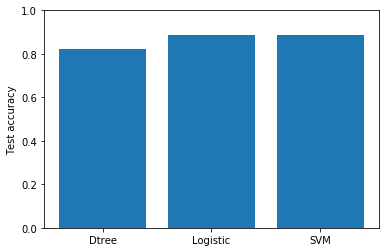

In [13]:
# Use White Percentage Only
Y_white = numeric_data['2018 Outcome']
X_white = numeric_data[['White Pct', '2012 Outcome', '2014 Outcome', '2016 Outcome']]
X_train, X_test, Y_train, Y_test = train_test_split(X_white, Y_white, test_size=0.3, random_state=1)

clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
tree_acc=accuracy_score(Y_test, Y_pred)

clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
logistic_acc=accuracy_score(Y_test, Y_pred)

clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
svm_acc=accuracy_score(Y_test, Y_pred)

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

In [14]:
"""
Next, test how accurate the prediction for swing states using stable districts 
as the training set, and swing districts as the test set.

Stable district: Same election result for 2012, 2014, 2016 election
Swing district: District switches from one party to another in at least one election.
"""

swing_districts=pd.DataFrame(columns=numeric_data.columns.values)
stable_districts=pd.DataFrame(columns=numeric_data.columns.values)
# swing_districts=pd.read_csv("ProjectDataset.csv")
for index, row in numeric_data.iterrows():
    if numeric_data.loc[index, '2012 Outcome'] != numeric_data.loc[index, '2014 Outcome'] or numeric_data.loc[index, '2014 Outcome'] != numeric_data.loc[index, '2016 Outcome']:
        # inconsistent election results
        swing_districts.loc[index] = row
    else:
        # consistent election results
        stable_districts.loc[index] = row
stable_districts.head()

,State,District,Total Population,Median Age,Male Pop,Female Pop,Male Pct,White Pop,White Pct,2012 Outcome,2014 Outcome,2016 Outcome,2018 Outcome
0,Alabama,1,713410,40.0,343769,369641,0.481867,479792,0.672533,0,0,0,0
1,Alabama,2,673776,38.5,328474,345302,0.487512,434984,0.645591,0,0,0,0
2,Alabama,3,710488,38.1,346742,363746,0.488034,487936,0.686762,0,0,0,0
3,Alabama,4,685553,40.7,332923,352630,0.485627,594163,0.866692,0,0,0,0
4,Alabama,5,718713,39.5,353533,365180,0.491897,544610,0.757757,0,0,0,0


In [15]:
"""
Baseline model: Predict 2018 election results for swing districts using past election data.
"""

Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['2012 Outcome', '2014 Outcome', '2016 Outcome']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('int'), Y_stable.astype('int'))
Y_pred = clf.predict(swing_districts[['2012 Outcome', '2014 Outcome', '2016 Outcome']])
accuracy_score(swing_districts['2018 Outcome'].astype('int'), Y_pred.astype('int'))

0.38461538461538464

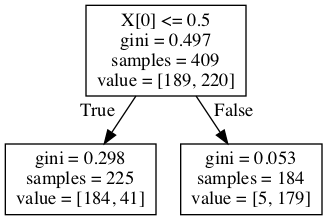

In [16]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("swingbase.pdf") 

Image(graph.create_png())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

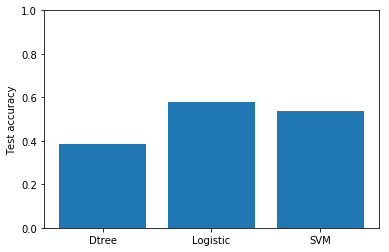

In [17]:
"""
Test with other classification methods
"""

#Decision Tree
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['2012 Outcome', '2014 Outcome', '2016 Outcome']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('int'), Y_stable.astype('int'))
Y_pred = clf.predict(swing_districts[['2012 Outcome', '2014 Outcome', '2016 Outcome']])
tree_acc=accuracy_score(swing_districts['2018 Outcome'].astype('int'), Y_pred.astype('int'))

# Logistic Regression
clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_stable.astype('int'), Y_stable.astype('int'))
Y_pred = clf.predict(swing_districts[['2012 Outcome', '2014 Outcome', '2016 Outcome']])
logistic_acc=accuracy_score(swing_districts['2018 Outcome'].astype('int'), Y_pred.astype('int'))

# Support Vector Machine
clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_stable.astype('int'), Y_stable.astype('int'))
Y_pred = clf.predict(swing_districts[['2012 Outcome', '2014 Outcome', '2016 Outcome']])
svm_acc=accuracy_score(swing_districts['2018 Outcome'].astype('int'), Y_pred.astype('int'))

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

In [18]:
"""
Now test if adding demographics improves this accuracy.
"""

Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct', '2012 Outcome', '2014 Outcome', '2016 Outcome']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct', '2012 Outcome', '2014 Outcome', '2016 Outcome']])
accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

0.4230769230769231

In [19]:
"""
Now test if only using demographics improves this accuracy.
"""

Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct']])
accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

0.6153846153846154

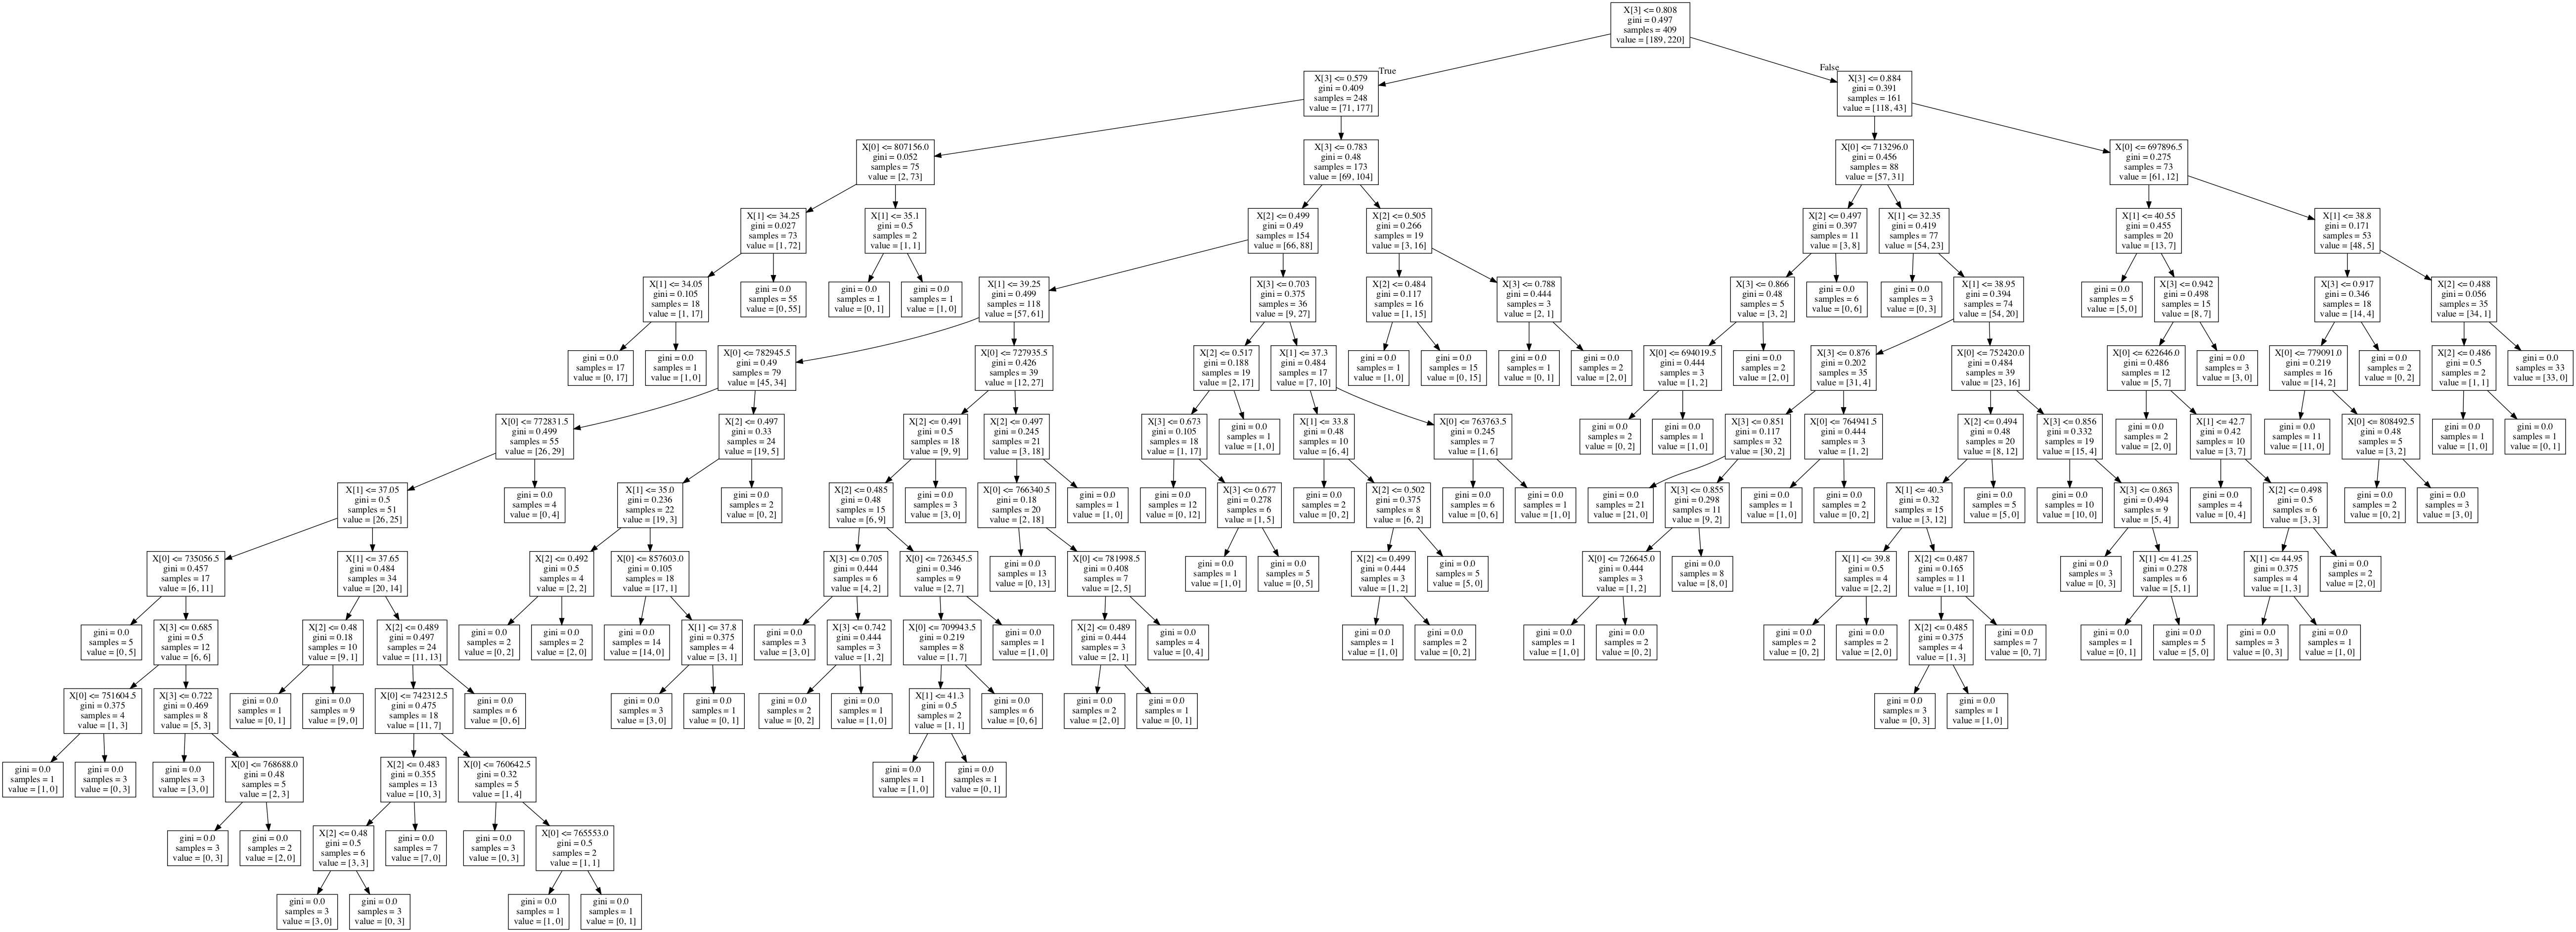

In [20]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("swingdemographics.pdf") 

Image(graph.create_png())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

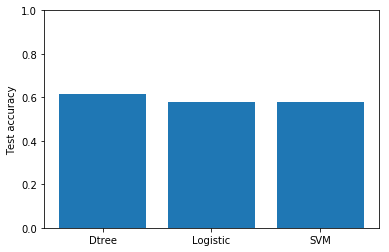

In [21]:
"""
Test with other classification methods
"""

#Decision Tree
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct']])
tree_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Logistic Regression
clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct']])
logistic_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Support Vector Machine
clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Total Population', 'Median Age', 'Male Pct', 'White Pct']])
svm_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

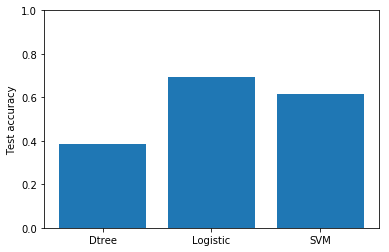

In [22]:
# Test without Total Population

#Decision Tree
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Median Age', 'Male Pct', 'White Pct']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Median Age', 'Male Pct', 'White Pct']])
tree_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Logistic Regression
clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_stable.astype('int'), Y_stable.astype('int'))
Y_pred = clf.predict(swing_districts[['Median Age', 'Male Pct', 'White Pct']])
logistic_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Support Vector Machine
clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_stable.astype('int'), Y_stable.astype('int'))
Y_pred = clf.predict(swing_districts[['Median Age', 'Male Pct', 'White Pct']])
svm_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

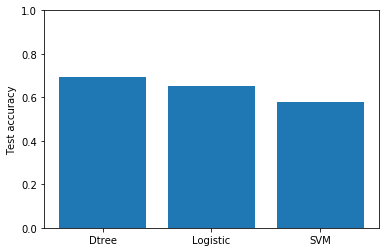

In [23]:
"""
Now determine which demographic leads to the best accuracy
"""

# Median Age

#Decision Tree
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Median Age']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Median Age']])
tree_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Logistic Regression
clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Median Age']])
logistic_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Support Vector Machine
clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Median Age']])
svm_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

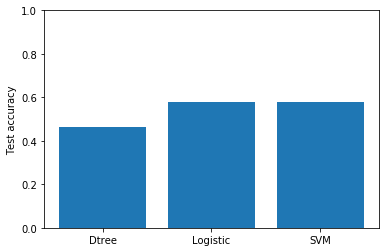

In [24]:
# Male Pct

#Decision Tree
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Male Pct']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Male Pct']])
tree_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Logistic Regression
clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Male Pct']])
logistic_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Support Vector Machine
clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Male Pct']])
svm_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.0, 1.0)

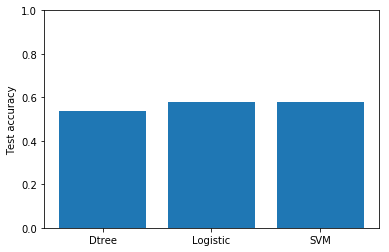

In [25]:
# White Pct

#Decision Tree
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['White Pct']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['White Pct']])
tree_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Logistic Regression
clf = linear_model.LogisticRegression(C=10)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['White Pct']])
logistic_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

# Support Vector Machine
clf = SVC(C=10,kernel='linear')
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['White Pct']])
svm_acc=accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

methods = ['Dtree', 'Logistic', 'SVM']
acc = [tree_acc, logistic_acc, svm_acc]
plt.bar([1.5,2.5,3.5],acc)
plt.xticks([1.5,2.5,3.5], methods)
plt.ylabel('Test accuracy')
plt.ylim([0.0,1.0])

In [26]:
# DecisionTree using Median Age as the attribute gives us the best accuracy
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Median Age']]
clf = tree.DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Median Age']])
accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

0.6923076923076923

Best hyperparameter, maxdepth = 2
Test Accuracy = 0.5769230769230769


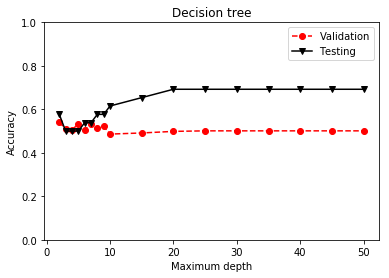

In [27]:
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
validationAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

numFolds = 20
index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=1)
    scores = cross_val_score(clf, X_stable.astype('double'), Y_stable.astype('double'), cv=numFolds)
    validationAcc[index] = np.mean(scores)
    
    clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
    Y_pred = clf.predict(swing_districts[['Median Age']])
    testAcc[index] = accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))
    index += 1
    
plt.plot(maxdepths, validationAcc, 'ro--', maxdepths, testAcc, 'kv-')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.title('Decision tree')
plt.legend(['Validation','Testing'])
plt.ylim([0.0,1.0])

bestHyperparam = np.argmax(validationAcc)
print('Best hyperparameter, maxdepth =', maxdepths[bestHyperparam])
print('Test Accuracy =', testAcc[bestHyperparam])

Best hyperparameter, maxdepth = 2
Test Accuracy = 0.6538461538461539


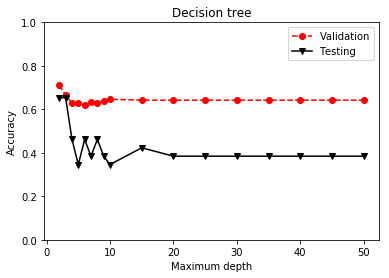

In [28]:
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
validationAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

numFolds = 20
index = 0
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Median Age', 'Male Pct', 'White Pct']]
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=1)
    scores = cross_val_score(clf, X_stable.astype('double'), Y_stable.astype('double'), cv=numFolds)
    validationAcc[index] = np.mean(scores)
    
    clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
    Y_pred = clf.predict(swing_districts[['Median Age', 'Male Pct', 'White Pct']])
    testAcc[index] = accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))
    index += 1
    
plt.plot(maxdepths, validationAcc, 'ro--', maxdepths, testAcc, 'kv-')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.title('Decision tree')
plt.legend(['Validation','Testing'])
plt.ylim([0.0,1.0])

bestHyperparam = np.argmax(validationAcc)
print('Best hyperparameter, maxdepth =', maxdepths[bestHyperparam])
print('Test Accuracy =', testAcc[bestHyperparam])



In [29]:
Y_stable = stable_districts['2018 Outcome']
X_stable = stable_districts[['Median Age']]
clf = tree.DecisionTreeClassifier(max_depth=20, random_state=1)
clf = clf.fit(X_stable.astype('double'), Y_stable.astype('double'))
Y_pred = clf.predict(swing_districts[['Median Age']])
accuracy_score(swing_districts['2018 Outcome'].astype('double'), Y_pred.astype('double'))

0.6923076923076923

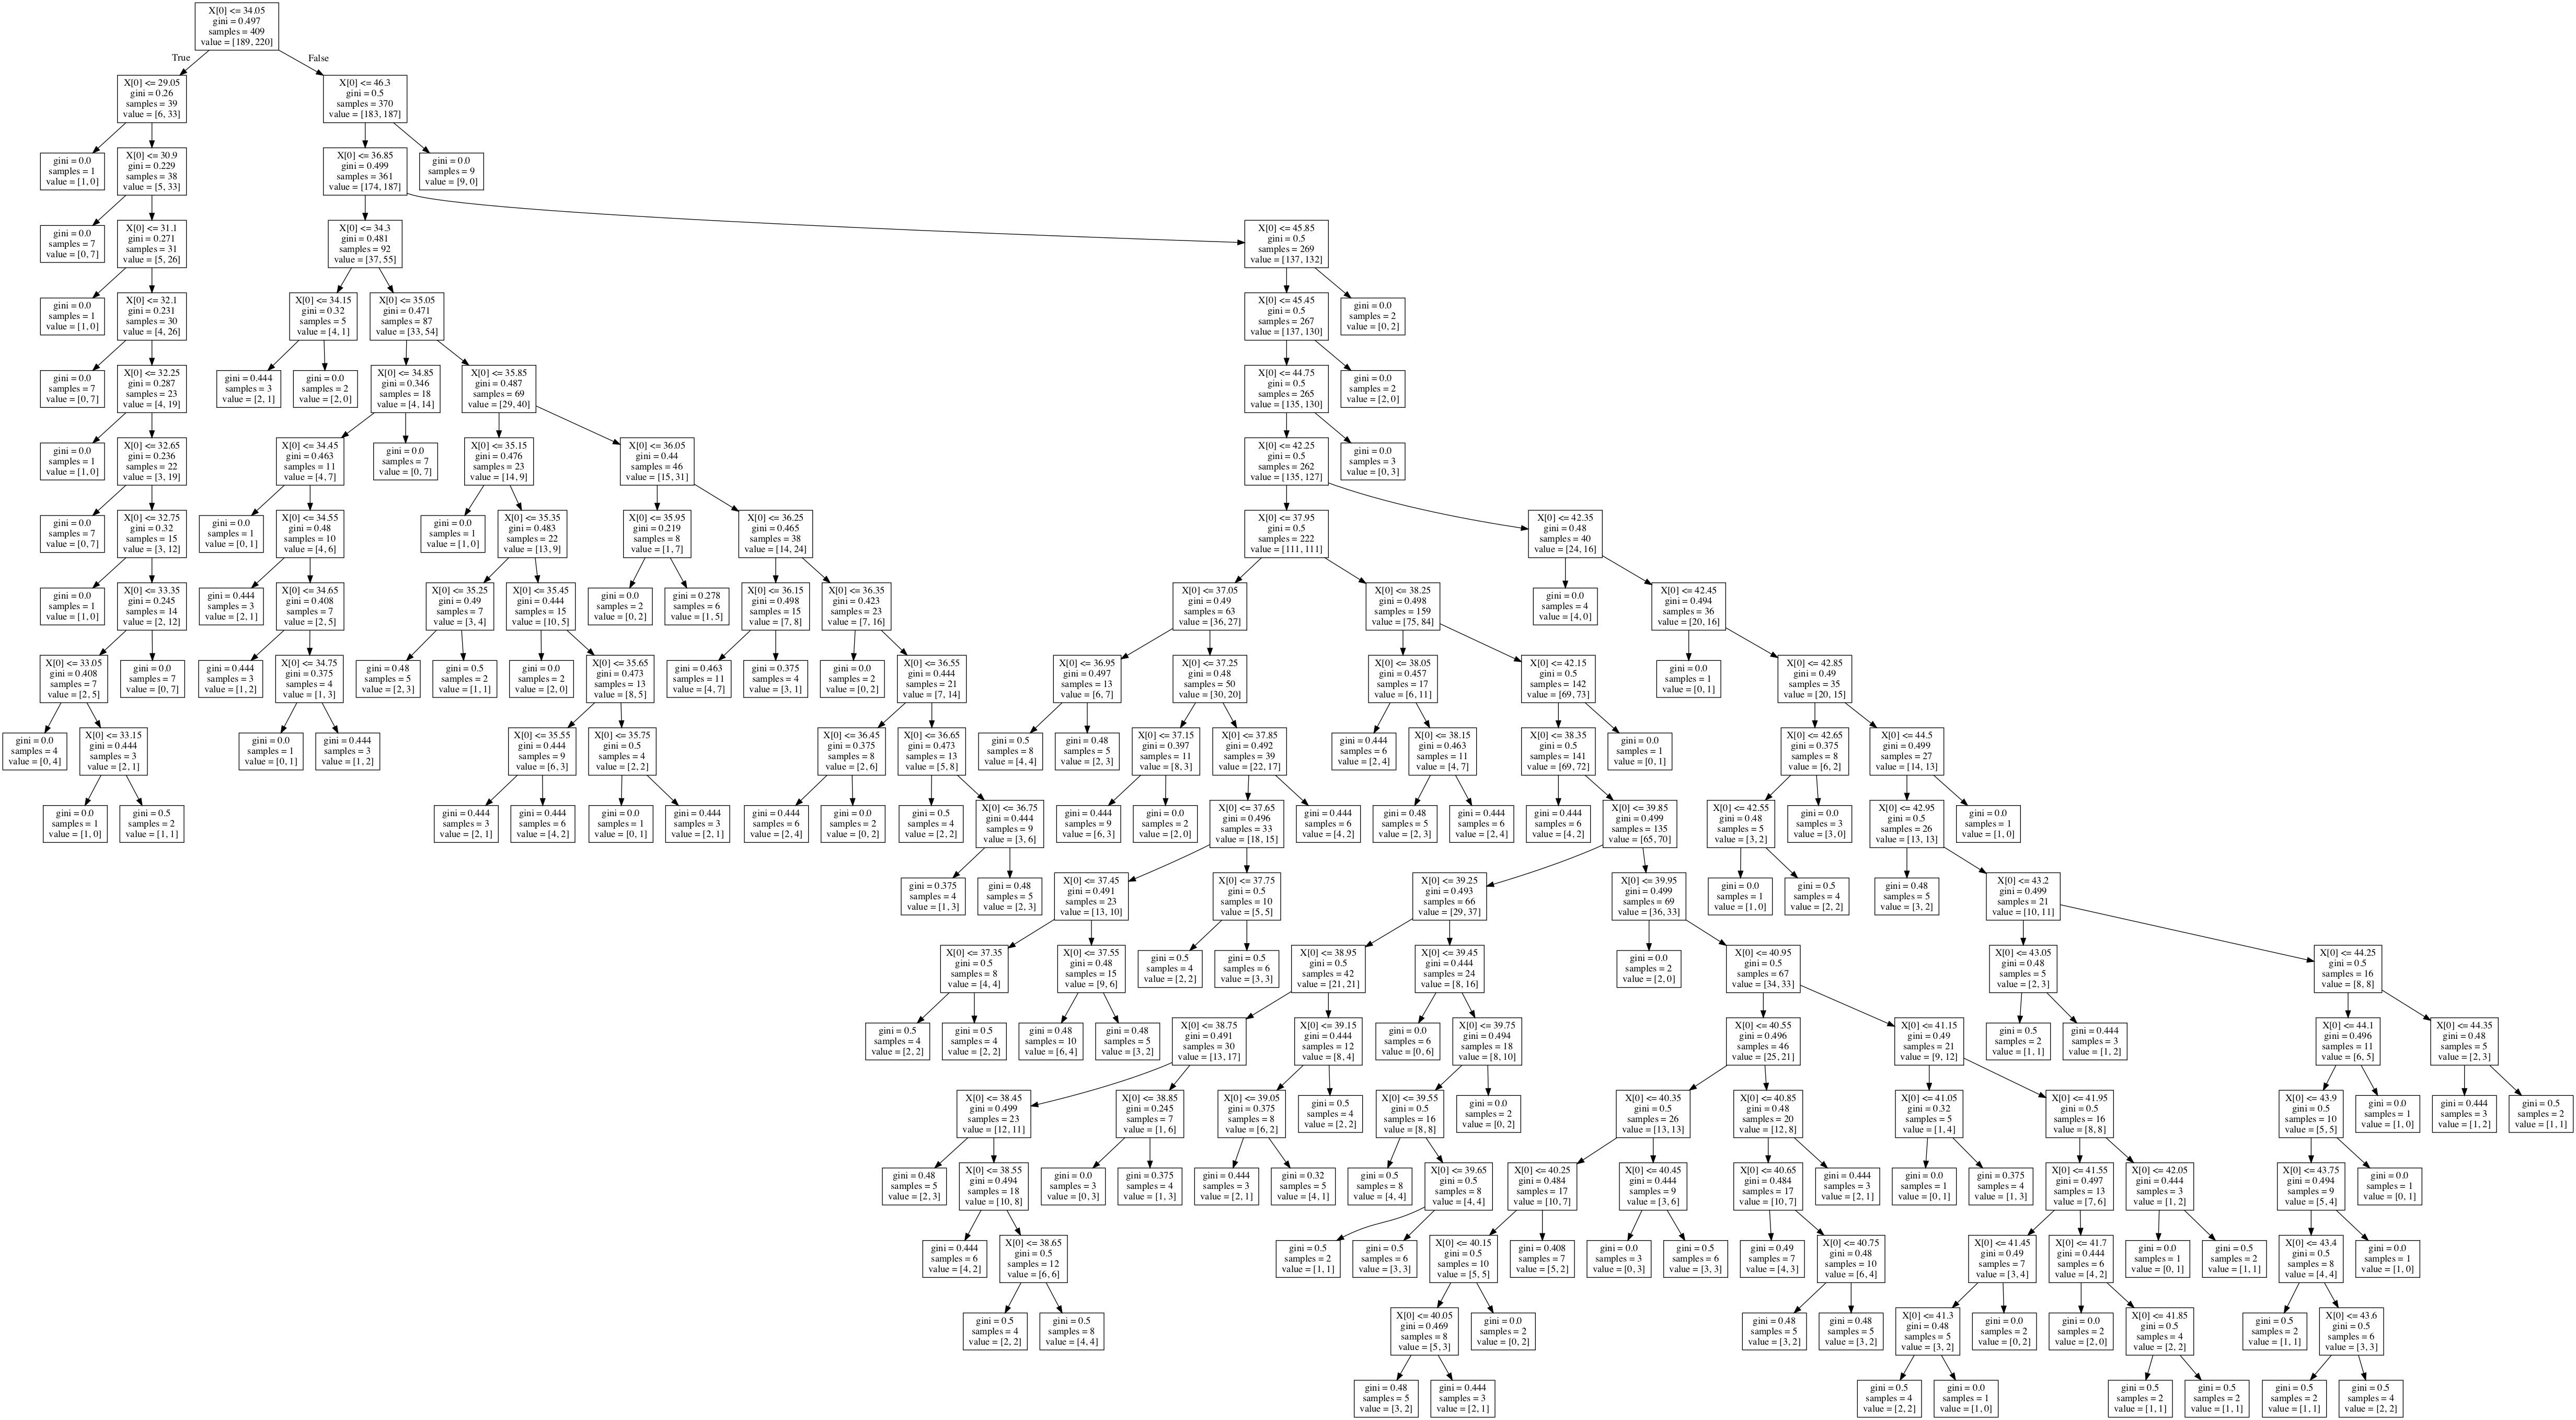

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("swingfinaltree.pdf") 

Image(graph.create_png())